# Melhor horário para ligar

Vamos construir um modelo para estimar (por cluster) a probabilidade de uma ligação ser atendida.

In [1]:
# importando módulos
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.random import normal
plt.style.use('bmh')

## Dados sintéticos

Vamos gerar dados sintéticos para exemplificar o funcionamento do modelo.

Nesse caso, a probabilidade de clientes de um mesmo cluster atenderem é 

$\large P(atender | ligou) \sim \mathcal{N}(10, 0.5) + \mathcal{N}(16, 0.5)$

e a probabilidade de fazermos uma ligação (por conta das nossas operações) é 

$\large P(ligou) \sim \mathcal{N}(14, 2)$

Vamos gerar os dados e depois testar um modelo que recupera essas informações!

In [2]:
# funções para gerar os dados
p_call = norm(14, 2)
p_answer = lambda x: norm(10,0.5).pdf(x) + norm(16,0.5).pdf(x) 

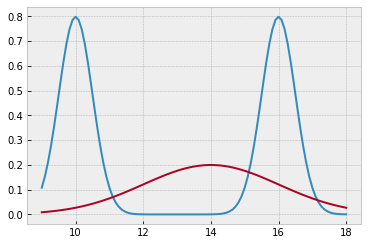

In [3]:
# vamos ver como isso se comporta
x_grid = np.linspace(9, 18, 100) # isso são os horários
plt.plot(x_grid, [p_answer(e) for e in x_grid])
plt.plot(x_grid, [p_call.pdf(e) for e in x_grid])

In [4]:
# vamos gerar dados sintéticos #

# 1000 amostras da distribuição de ligaçoes
ligacoes = p_call.rvs(1000)

# gerando uma variável binária com bases nas probabilidades de atendimento
atendimentos = np.array([p_answer(e) > np.random.random() for e in ligacoes]).astype(int)

In [5]:
# nossa variável de horário de ligações fica assim...
ligacoes

array([13.93134365, 12.05915356, 13.98513031, 12.60450743, 17.87100223,
       12.78889252, 15.8491186 , 14.8941818 , 14.89147869, 16.24300479,
       11.99268823, 12.41856642, 14.55615213, 13.67191969, 12.35426746,
       12.78022639, 15.34531537, 13.23842801, 16.15048715, 14.50791796,
       13.21064781, 12.74319816, 13.37354312, 12.61067208, 14.15780169,
       14.27669937, 17.36521527, 16.17700649, 19.44404675, 12.26987815,
       16.35670279, 11.70095223, 12.56237517, 15.95649302, 13.22902784,
       14.35217842, 13.38671088, 15.97764758, 17.21719185, 11.40887823,
       15.39515998, 14.71935767, 17.28288896, 16.2518291 , 17.67294718,
       13.12498563, 11.9291081 , 15.17344373, 17.19866659, 14.18659009,
       19.25936181, 14.85388149, 14.10566368, 13.16879219, 12.09997171,
       17.6645284 , 15.79777447, 15.00922885, 16.96304748, 13.2938983 ,
       11.57118084, 11.22140574, 15.03437062, 14.81176105, 18.72438874,
       16.46386257, 15.47692271, 11.91165542, 13.44184064, 12.52

In [6]:
# nossa variável de atendimentos fica assim...
atendimentos

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

## Modelo

Vamos resolver esse negócio usando a regra de Bayes (ou teorema da probabilidade condicional)

$$\large P(A | B) = \frac{P(B | A) P(A)}{P(B)}$$

No nosso caso, $A = atender$, $B = ligar$. Então a fórmula fica assim:

$$\large P(atender | ligar) = \frac{P(ligar | atender) P(atender)}{P(ligar)}$$

$\large P(atender)$ é o mais fácil, é simplesmente a chance de qualquer ligação ser atendida:

In [7]:
atendimentos.mean()

0.133

$\large P(ligar)$ pode ser modelado como um histograma dos horários de cada ligação:

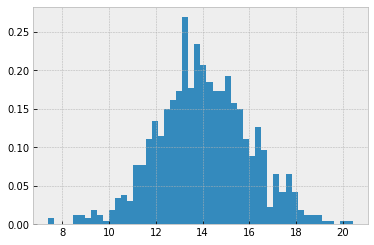

In [12]:
plt.hist(ligacoes, bins=50, density=True);

mas pra melhorar isso, a gente usa o [`KernelDensity`](https://scikit-learn.org/stable/modules/density.html) do `sklearn` para suavizar o histograma:

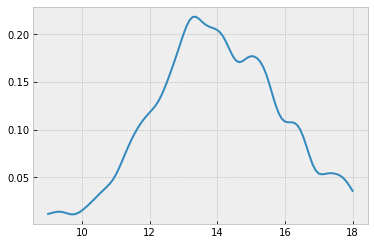

In [9]:
# importando a biblioteca
from sklearn.neighbors import KernelDensity

# vamos ajustar o modelo de P(ligacao)
p_ligacao_model = KernelDensity(bandwidth=0.25) 
p_ligacao_model.fit(ligacoes.reshape(-1,1))

# vamos ver se ele prevê bem
x_grid = np.linspace(9, 18, 100)
previsoes_ligacao = np.exp(p_ligacao_model.score_samples(x_grid.reshape(-1,1)))
plt.plot(x_grid, previsoes_ligacao);

Finalmente, $\large P(ligar | atender)$ também pode ser modelado com `KernelDensity`, mas somente sobre as ligações que foram atendidas:

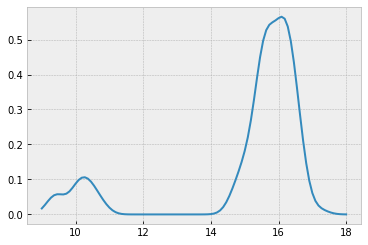

In [10]:
# vamos ajustar o modelo de atendimento
p_atendimento_model = KernelDensity(bandwidth=0.25) 
p_atendimento_model.fit(ligacoes[atendimentos == 1].reshape(-1,1))

# vamos ajustar um modelo total
x_grid = np.linspace(9, 18, 100)
previsoes_atendimento = np.exp(p_atendimento_model.score_samples(x_grid.reshape(-1,1)))
plt.plot(x_grid, previsoes_atendimento);

juntando tudo, eu consigo chegar na curva que eu gostaria!

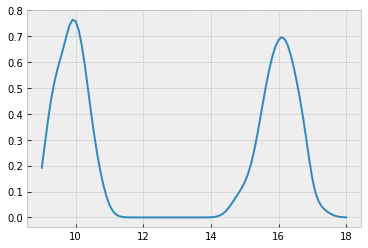

In [13]:
# juntando tudo na regra de bayes
prob_atender_dado_que_ligou = previsoes_atendimento*atendimentos.mean()/previsoes_ligacao

# plotando
plt.plot(x_grid, prob_atender_dado_que_ligou);

## NOTAS ADICIONAIS

1. **Parâmetro `bandwidth` do `KernelDensity`:** quanto maior esse parâmetro, mais suave fica o histograma. Valores muito altos não vão capturar todas as nuances, valores muito baixos vão deixar o histograma muito "rasgado" (isso é análogo ao tamanho do bin no histograma). Vale testar alguns valores e chegar em um bom equilíbrio.

2. **Como construir os clusters:** uma ideia é que a metodologia de construção dos clusters que mais minimizar a entropia de $P(ligar | atender)$ deve ser a melhor. Quanto maior a entropia, mais perto de uma distribuição uniforme a gente está, o que quer dizer que dentro de um mesmo cluster temos muitos comportamentos distintos (eles não concentram em nenhum horário).